## Imports and setup

In [ ]:
# Grab data from ACS with cenpy (don't need to run every time!)
# Variables:
#    - total population (B01003_001E)
#    - total white (B02008_001E)
#    - total black (B02009_001E)
#    - total asian (B02011_001E)
#    - total hispanic (B03001_003E)
#    - median household income (B19013_001E)
#    - median house price (B25077_001E)
#    - total tenure (B25032_001E)
#    - total owner occupied (B25032_002E)
#    - total renter occupied (B25032_007E)
#    - median contract rent (B25064_001E)
#    - total in labor force (B23025_002E)
#    - total employed (civilian) (B23025_004E)
#    - total unemployed (civilian) (B23025_005E)

countydata = gpd.GeoDataFrame()

states = pd.read_csv('../utils/states.csv')['State'].values
for state in tqdm(states):
    countydata = countydata.append(acs.from_state(state=state, variables=variables, level='county'))

countydata.to_csv('../data/ACS_countydata.csv')

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import stan_jupyter as stan
from scipy.linalg import norm

from tqdm import tqdm
from cenpy.products import ACS
from spint.gravity import Gravity, Attraction, Production

acs = ACS()
LA_FIPS = '06037'  # LA County FIPS code
variables = ['B01003_001E', 'B02008_001E', 'B02009_001E', 'B02011_001E', 'B03001_003E', \
    'B19013_001E', 'B25077_001E', 'B25032_001E', 'B25032_002E', 'B25032_007E', \
    'B25064_001E', 'B23025_002E', 'B23025_004E', 'B23025_005E']

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [26]:
def tile_la_vars(vars, data, shape):
    return np.tile(data[vars].values, (shape, 1))  # repeat the data so that we account for the single location properly

## Load data

In [2]:
# Flows
inflows_raw = pd.read_csv('../data/LACounty_ACS_2014_2018_All_IN.csv', usecols=['State/County FIPS', 'Total', 'Margin of Error (+/-)']).replace("'", "", regex=True)
outflows_raw = pd.read_csv('../data/LACounty_ACS_2014_2018_All_OUT.csv', usecols=['State/County FIPS', 'Total', 'Margin of Error (+/-)']).replace("'", "", regex=True)
outflows_raw.rename(columns={'State/County FIPS' : 'destFIPS', 'Total' : 'total_out', 'Margin of Error (+/-)' : 'outMOE'}, inplace=True)
inflows_raw.rename(columns={'State/County FIPS' : 'originFIPS', 'Total' : 'total_in', 'Margin of Error (+/-)' : 'inMOE'}, inplace=True)

In [3]:
# County-level demographic data (and convert covariate columns)
countydata = gpd.read_file('../data/ACS_countydata.csv', GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO").replace('', 0)
for var in variables:
    countydata[var] = countydata[var].astype(float)

In [4]:
# Ping ACS for data for LA county
la_data = acs.from_county("Los Angeles County, CA", variables=variables, level='county')

In [5]:
# Convert races, employment to percents
countydata['pctwhite'] = countydata['B02008_001E'] / countydata['B01003_001E']
countydata['pctblack'] = countydata['B02009_001E'] / countydata['B01003_001E']
countydata['pctasian'] = countydata['B02011_001E'] / countydata['B01003_001E']
countydata['pcthispa'] = countydata['B03001_003E'] / countydata['B01003_001E']
countydata['pctemplo'] = countydata['B23025_004E'] / countydata['B23025_002E']
countydata['pctunemp'] = countydata['B23025_005E'] / countydata['B23025_002E']
countydata['pctowner'] = countydata['B25032_002E'] / countydata['B25032_001E']
countydata['pctrentr'] = countydata['B25032_007E'] / countydata['B25032_001E']

la_data['pctwhite'] = la_data['B02008_001E'] / la_data['B01003_001E']
la_data['pctblack'] = la_data['B02009_001E'] / la_data['B01003_001E']
la_data['pctasian'] = la_data['B02011_001E'] / la_data['B01003_001E']
la_data['pcthispa'] = la_data['B03001_003E'] / la_data['B01003_001E']
la_data['pctemplo'] = la_data['B23025_004E'] / la_data['B23025_002E']
la_data['pctunemp'] = la_data['B23025_005E'] / la_data['B23025_002E']
la_data['pctowner'] = la_data['B25032_002E'] / la_data['B25032_001E']
la_data['pctrentr'] = la_data['B25032_007E'] / la_data['B25032_001E']

In [7]:
# Rename remaining columns and record plaintext variables
countydata.rename(columns={'B25064_001E' : 'medrent', 'B19013_001E' : 'medincome', 'B25077_001E' : 'medhprice'}, inplace=True)

## Rearrage data to prep for analysis

In [27]:
# Merge all the data into one big dataframe to make it simpler
data = pd.merge(pd.merge(countydata, outflows_raw, how='inner', left_on='GEOID', right_on='destFIPS'), inflows_raw, how='inner', left_on='GEOID', right_on='originFIPS').set_crs(epsg=3395)
la_data.rename(columns={'B25064_001E' : 'medrent', 'B19013_001E' : 'medincome', 'B25077_001E' : 'medhprice'}, inplace=True)
la_covars = tile_la_vars(plainvars, la_data, data.shape[0])

In [28]:
# costs are all distances between LA and the out or in destination
coords = np.hstack((data.centroid.x.values.reshape(-1, 1), data.centroid.y.values.reshape(-1, 1)))
la_coords = np.array([la_data.centroid.x[0], la_data.centroid.y[0]])
cost = norm(la_coords - coords, axis=1)

In [29]:
# Make data arrays w/o outliers
data_noouts = data[data['total_out'] < 5000]
la_covars_noouts = tile_la_vars(plainvars, la_data, data_noouts.shape[0])  # repeat the data so that we account for the single location properly

In [30]:
# costs for no outliers arrays
coords_noouts = np.hstack((data_noouts.centroid.x.values.reshape(-1, 1), data_noouts.centroid.y.values.reshape(-1, 1)))
la_coords_noouts = np.array([la_data.centroid.x[0], la_data.centroid.y[0]])
cost_noouts = norm(la_coords_noouts - coords_noouts, axis=1)

## Pre-analysis diagnostics

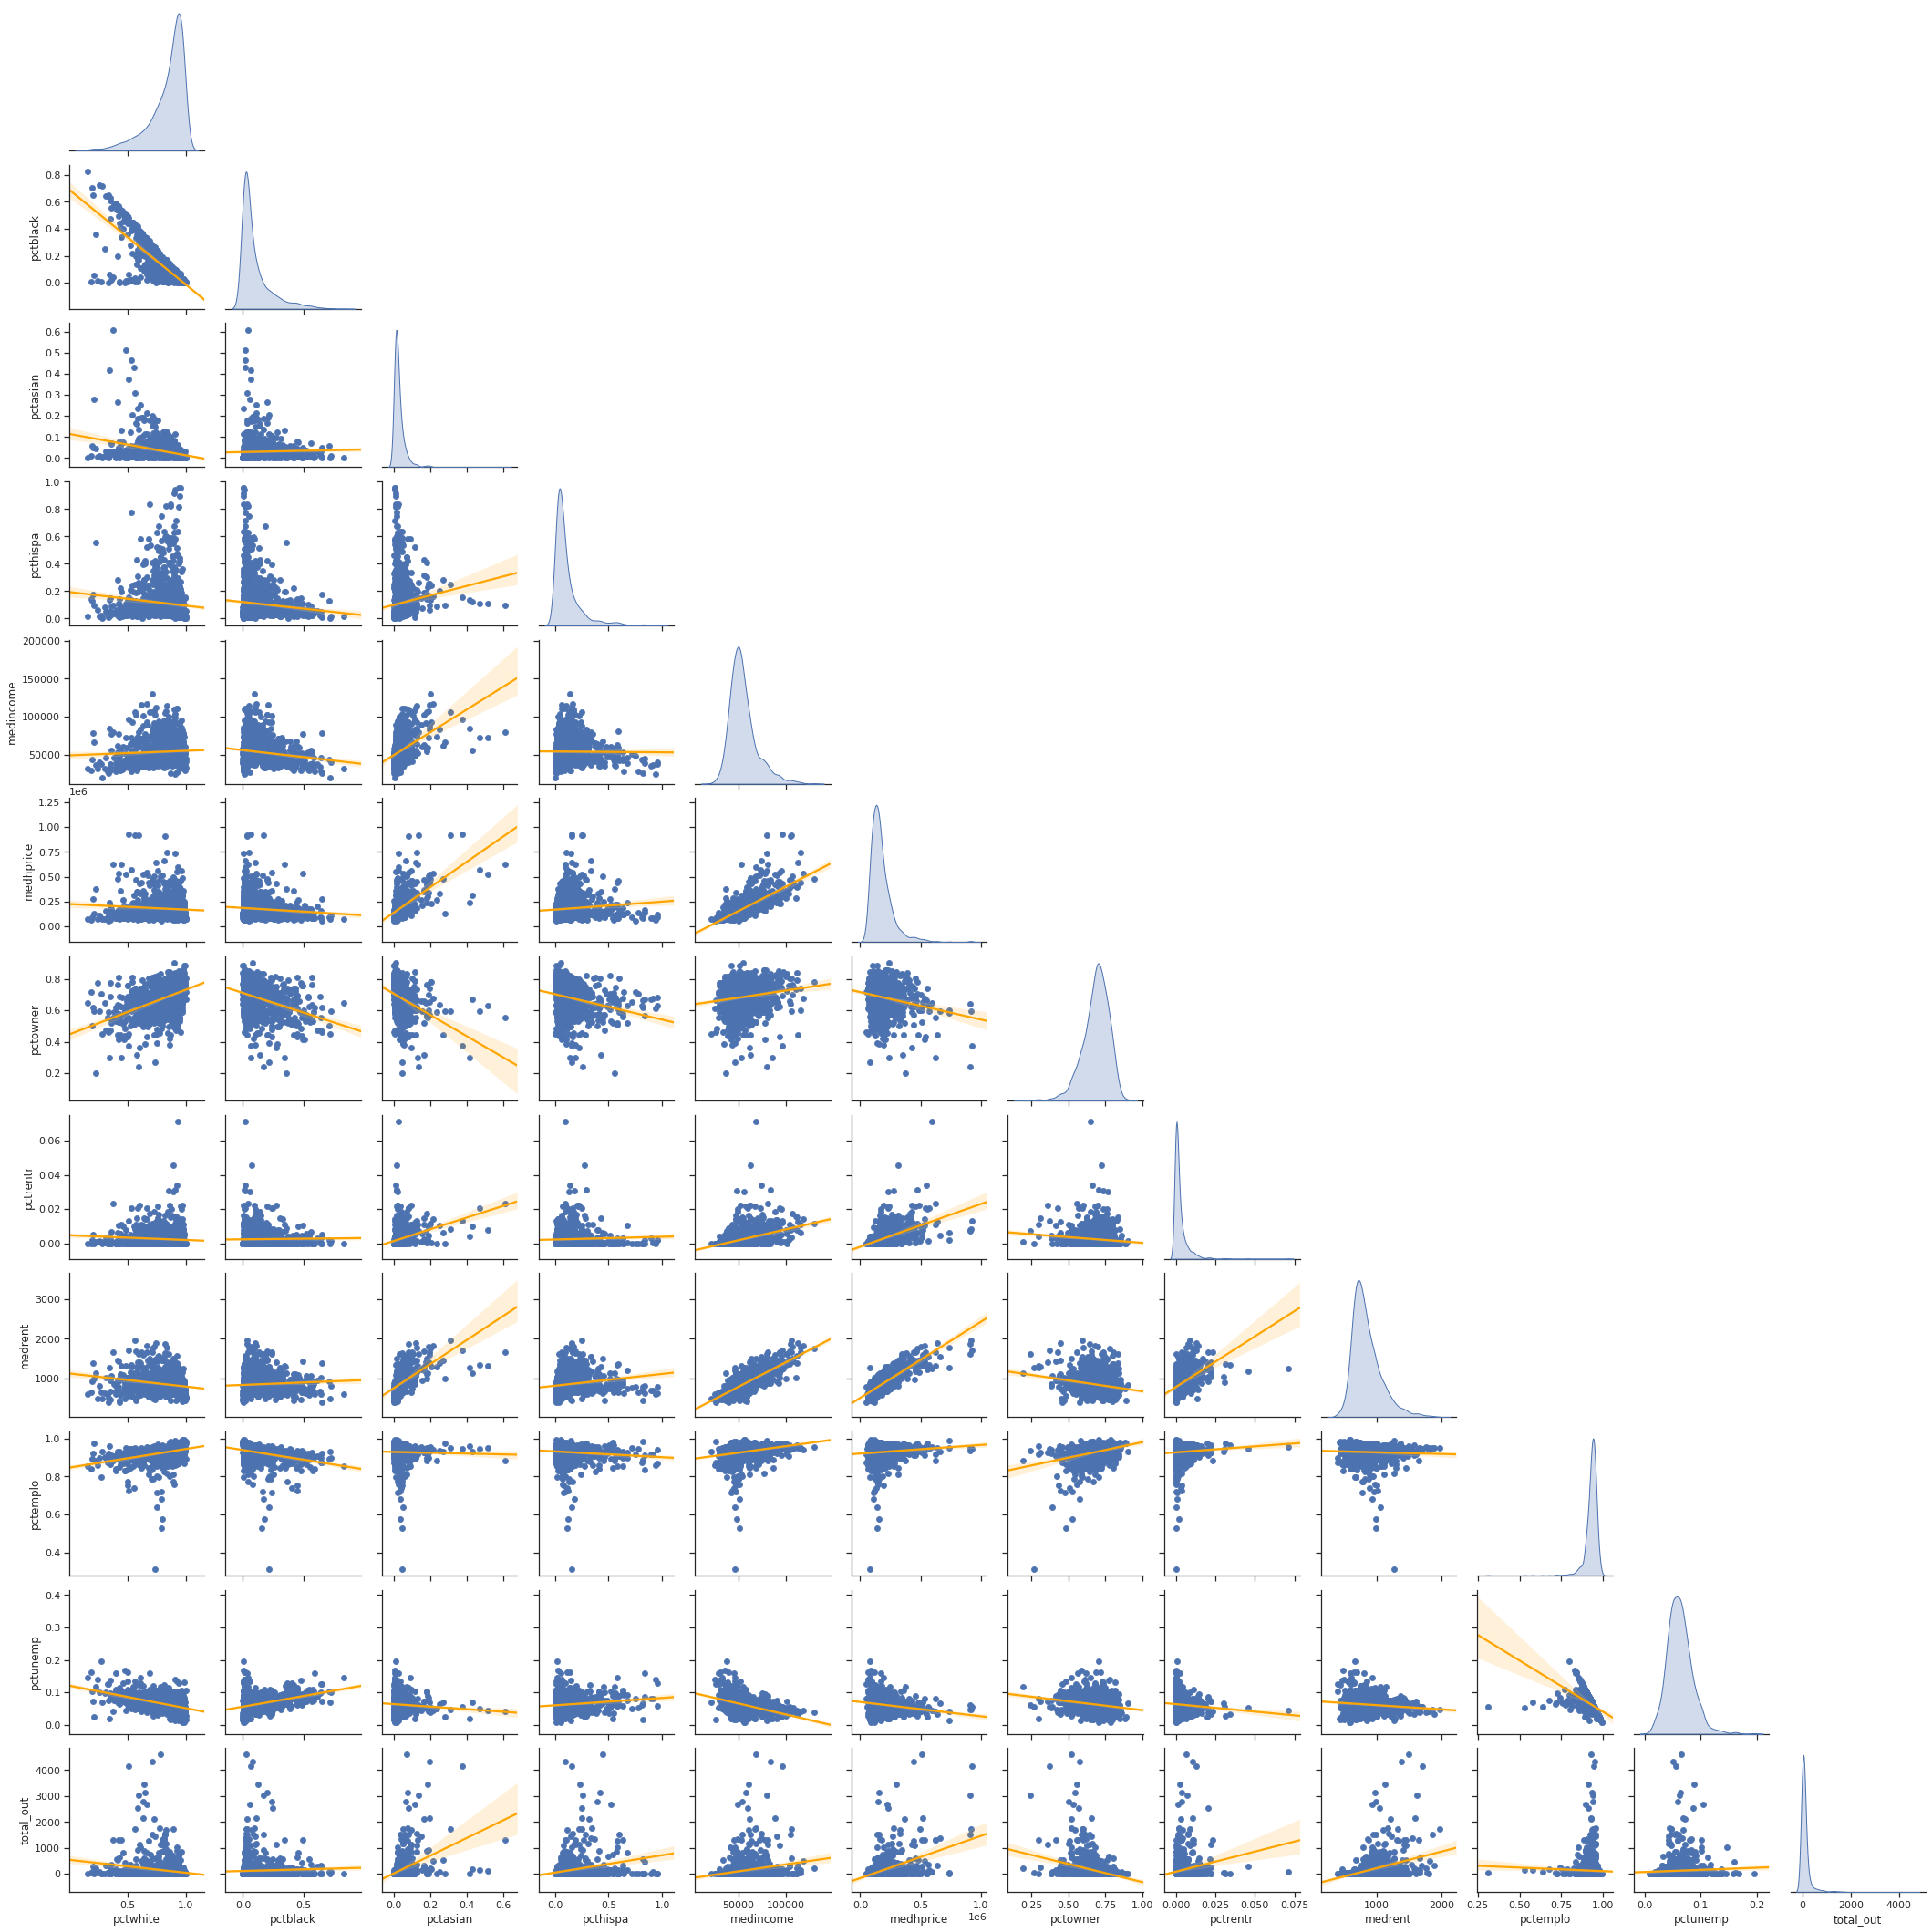

In [11]:
allvars = ['pctwhite', 'pctblack', 'pctasian', 'pcthispa', \
    'medincome', 'medhprice', 'pctowner', 'pctrentr', \
    'medrent', 'pctemplo', 'pctunemp']

sns.set_theme(style='ticks')
corrs = sns.pairplot(data_noouts[allvars + ['total_out']], diag_kind='kde', corner=True)
corrs.map_lower(sns.regplot, truncate=False, line_kws={"color": "orange"})
plt.savefig('../pics/scatterplot-matrix.png')

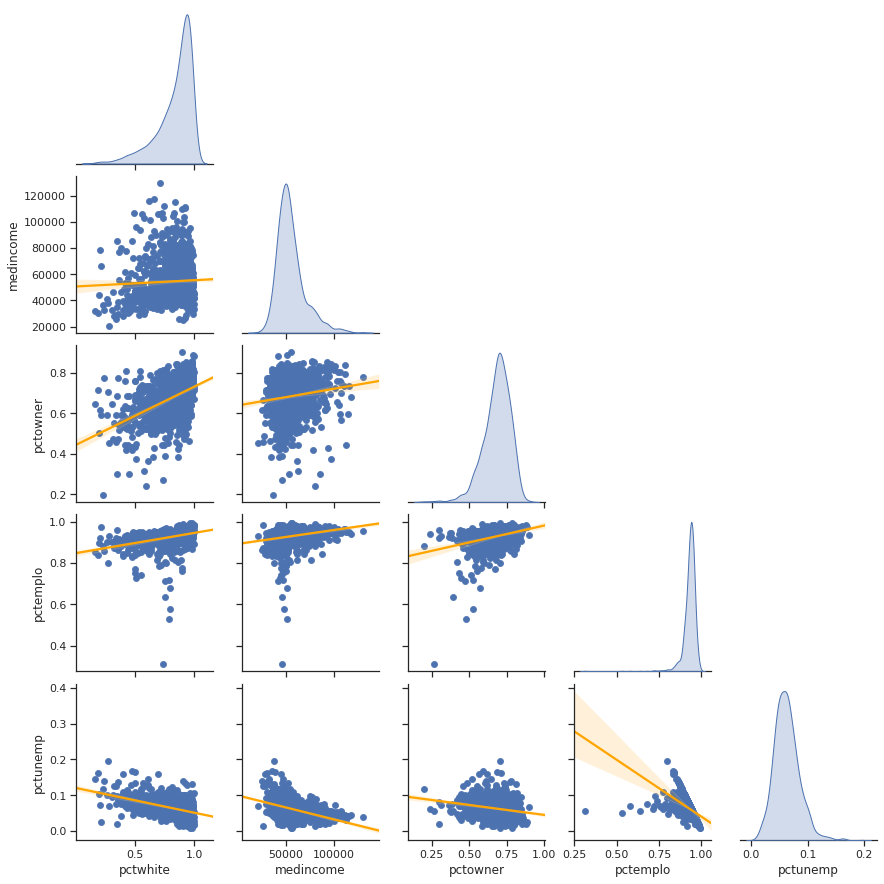

In [12]:
# Plot correlations to survey the data
sns.set_theme(style='ticks')
corrs = sns.pairplot(data[plainvars], diag_kind='kde', corner=True)
corrs.map_lower(sns.regplot, truncate=False, line_kws={"color": "orange"})

It looks like there's some collinearity between `medincome` and `medrent` as well as `medhprice` and `medrent`. Let's remove `medrent` from the data and see what happens.

## Calibrate model 

In [83]:
plainvars = ['pctowner']
la_covars = tile_la_vars(plainvars, la_data, data.shape[0])
la_covars_noouts = tile_la_vars(plainvars, la_data, data_noouts.shape[0])
# Problems: medincome, medhprice, medrent: one or more arrays have missing or NaN
#           pctowner, pctrentr, pctemplo, pctunemp: gives NaN SE and tvalues in origin field

In [84]:
model = Gravity(flows=data_noouts['total_out'].values.reshape(-1, 1), o_vars=la_covars_noouts, d_vars=data_noouts[plainvars].values, cost=cost_noouts, cost_func='exp', constant=False)

In [85]:
paramnames = [*[x + '_o' for x in plainvars], *[x + '_d' for x in plainvars], 'distance']
ci_lb = model.params - 1.96 * model.std_err
ci_ub = model.params + 1.96 * model.std_err
ci = [f'[{x:2.3f}, {y:2.3f}]' for x, y in zip(ci_lb, ci_ub)]
pd.DataFrame(data={'paramname' : paramnames, 'paramval' : model.params, 'SE' : model.std_err, 'tvalue' : model.tvalues, 
                    'pvalue' : model.pvalues, 'CI' : ci})  # origin attrs, dest attrs, distance

,paramname,paramval,SE,tvalue,pvalue,CI
0,pctowner_o,-5.454397e+00,1.053054e-02,-517.959728,0.0,"[-5.475, -5.434]"
1,pctowner_d,-5.033923e+00,1.269255e-02,-396.604594,0.0,"[-5.059, -5.009]"
2,distance,-4.628870e-07,1.678633e-09,-275.752427,0.0,"[-0.000, -0.000]"


In [86]:
model.pseudoR2  # wow this is...truly terrible

0.16700224584879864

In [87]:
model.SRMSE

6.65236390678589

## Constrained models

In [208]:
cleaned_data = data[allvars].replace(0, 0.0001)
cleaned_data_noouts = data_noouts[allvars].replace(0, 0.0001)
o_ids = ['06037' for _ in range(data.shape[0])]
o_ids_noouts = ['06037' for _ in range(data_noouts.shape[0])]

In [209]:
out_model = Production(flows=data['total_out'].values, origins=o_ids, d_vars=cleaned_data[allvars].values, cost=cost, cost_func='exp')

In [213]:
paramnames = ['intercept'] + [x + '_d' for x in allvars] + ['distance']
ci_lb = out_model.params - 1.96 * out_model.std_err
ci_ub = out_model.params + 1.96 * out_model.std_err
ci = [f'[{x:2.3f}, {y:2.3f}]' for x, y in zip(ci_lb, ci_ub)]
pd.DataFrame(data={'paramname' : paramnames, 'paramval' : out_model.params, 'SE' : out_model.std_err, 'tvalue' : out_model.tvalues, 
                    'pvalue' : out_model.pvalues, 'CI' : ci})  # origin attrs, dest attrs, distance

,paramname,paramval,SE,tvalue,pvalue,CI
0,intercept,2.912514e+00,1.432879e-01,20.326304,7.526223e-92,"[2.632, 3.193]"
1,pctwhite_d,-3.667387e-01,1.141237e-02,-32.135191,1.422306e-226,"[-0.389, -0.344]"
2,pctblack_d,6.711479e-02,2.350302e-03,28.555819,2.378491e-179,"[0.063, 0.072]"
3,pctasian_d,2.975215e-01,2.900024e-03,102.592793,0.000000e+00,"[0.292, 0.303]"
4,pcthispa_d,5.165918e-02,2.724390e-03,18.961741,3.532519e-80,"[0.046, 0.057]"
5,medincome_d,-1.358647e-01,1.950445e-02,-6.965831,3.264709e-12,"[-0.174, -0.098]"
6,medhprice_d,-4.920538e-01,1.090504e-02,-45.121670,0.000000e+00,"[-0.513, -0.471]"
7,pctowner_d,-1.050111e+00,1.683034e-02,-62.393939,0.000000e+00,"[-1.083, -1.017]"
8,pctrentr_d,2.355103e-01,1.645430e-03,143.129933,0.000000e+00,"[0.232, 0.239]"
9,medrent_d,2.649917e+00,2.379947e-02,111.343498,0.000000e+00,"[2.603, 2.697]"


In [211]:
out_model.pseudoR2  # not bad

0.6645448794569595

In [212]:
out_model.SRMSE

6.054763898487538